In [17]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df = pd.read_csv('/content/drive/MyDrive/fashion_luxury_equity_data.csv', delimiter= ',')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Close,Volume,Ticker
0,2022-09-30,576.937622,477030.0,MC.PA
1,2022-10-03,574.669128,391198.0,MC.PA
2,2022-10-04,611.342102,574934.0,MC.PA
3,2022-10-05,602.362854,386410.0,MC.PA
4,2022-10-06,600.283447,227173.0,MC.PA
...,...,...,...,...
75126,2025-09-23,6.850000,1883000.0,FIGS
75127,2025-09-24,6.780000,2254000.0,FIGS
75128,2025-09-25,6.570000,1571800.0,FIGS
75129,2025-09-26,6.590000,1902600.0,FIGS


In [3]:
prada = df[df['Ticker'] == '1913.HK'].copy()
prada.reset_index(drop=True, inplace=True)
prada.pivot(index='Date', columns="Ticker", values='Close')

Ticker,1913.HK
Date,
2022-09-30,34.130188
2022-10-03,34.411480
2022-10-05,37.927639
2022-10-06,37.833874
2022-10-07,37.458817
...,...
2025-09-22,46.619999
2025-09-23,46.259998
2025-09-24,46.980000


<Axes: xlabel='Date'>

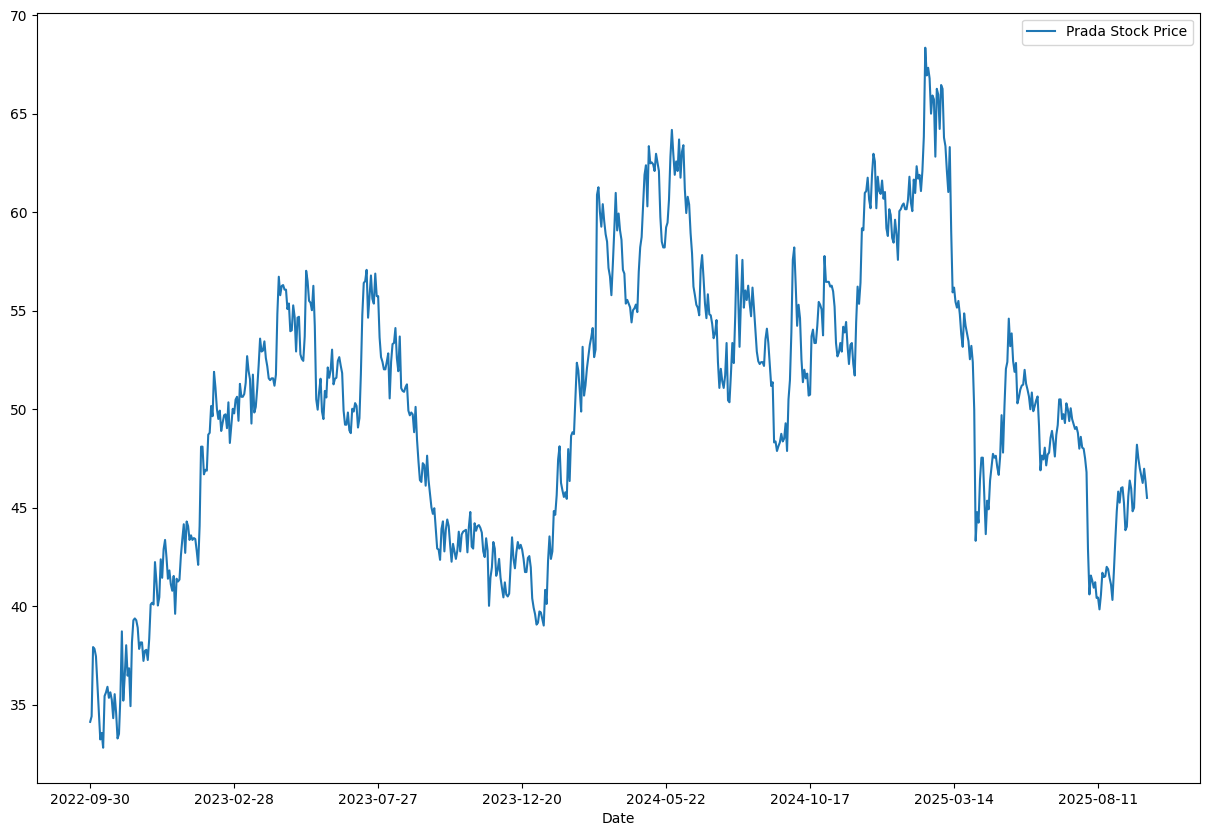

In [4]:
prada.plot(x='Date', y='Close', figsize=(15,10), label ='Prada Stock Price')

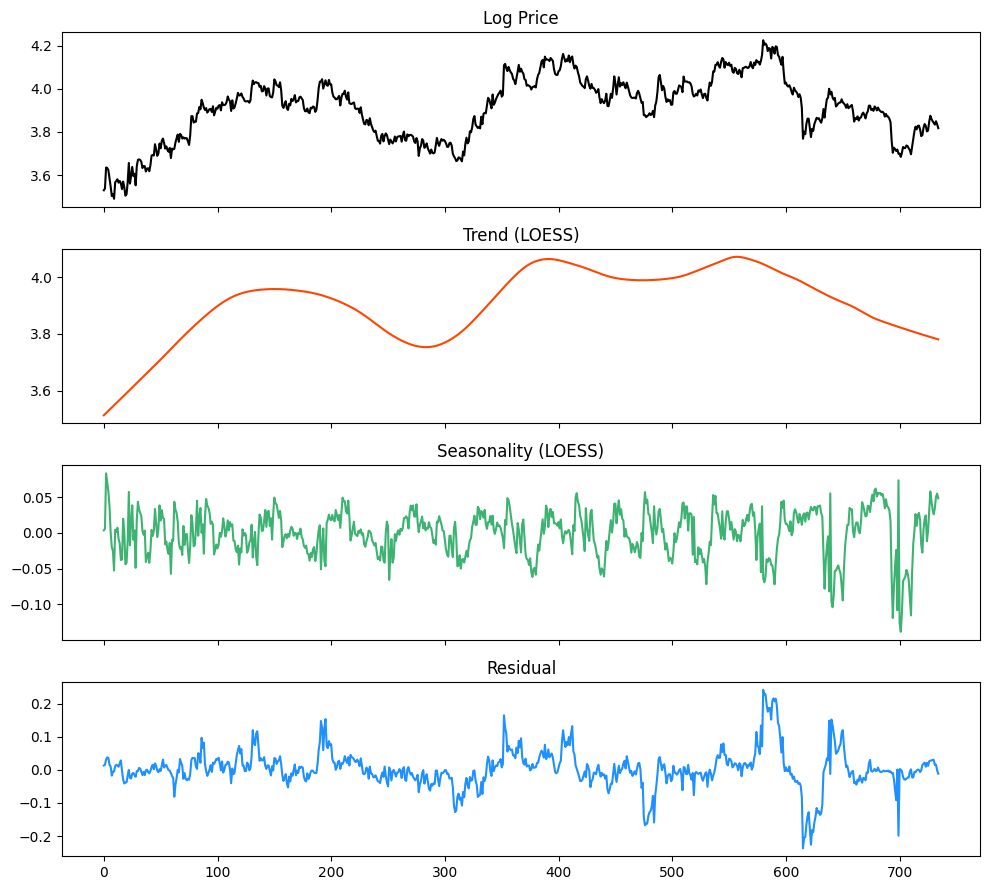

In [5]:
from statsmodels.tsa.seasonal import STL
log_price = np.log(prada['Close'])
stl = STL(log_price, period=60, robust=True)
result = stl.fit()
fig, axs = plt.subplots(4, 1, figsize=(10, 9), sharex=True)
axs[0].plot( log_price, label='Log Price', color='black')
axs[0].set_title("Log Price")
axs[1].plot( result.trend, label='Trend', color='orangered')
axs[1].set_title("Trend (LOESS)")
axs[2].plot(result.seasonal, label='Seasonal', color='mediumseagreen')
axs[2].set_title("Seasonality (LOESS)")
axs[3].plot( result.resid, label='Residuals', color='dodgerblue')
axs[3].set_title("Residual")
plt.tight_layout()
plt.show()

#II. Stationary Test

##1. ACF & PACF Plot


Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

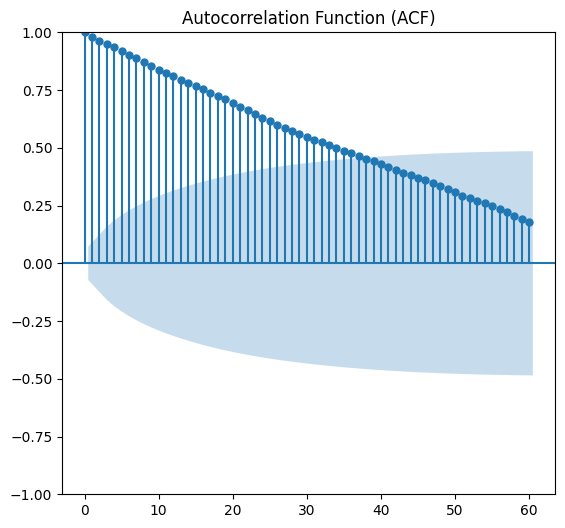

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(prada['Close'], ax=plt.gca(), lags=60)
plt.title('Autocorrelation Function (ACF)')

Text(0.5, 1.0, 'ACF after Differencing')

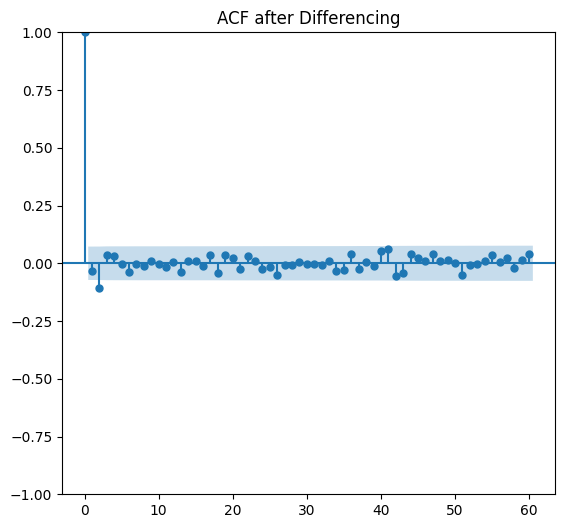

In [7]:
prada_diff = prada['Close'].diff().dropna()
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_acf(prada_diff, ax=plt.gca(), lags = 60)
plt.title('ACF after Differencing')

In [8]:
from statsmodels.tsa.stattools import adfuller
result_adf = adfuller(prada_diff)
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
for key, value in result_adf[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -21.7287292887106
p-value: 0.0
Critical Value (1%): -3.439314999916068
Critical Value (5%): -2.8654965012008677
Critical Value (10%): -2.5688768817372867


###PACF Plot


<Figure size 1400x600 with 0 Axes>

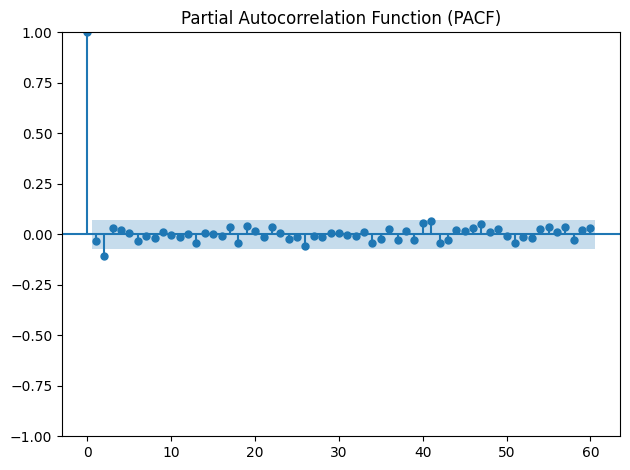

In [9]:
plt.figure(figsize=(14, 6))
plot_pacf(prada_diff, lags=60, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

##ARIMA Model

In [62]:
train_size = int(len(prada) * 0.8)
train_set = prada['Close'][:train_size]
test_set = prada['Close'][train_size:]

In [63]:
import warnings
import itertools
p = range(0, 5)
q = range(0, 5)
d = 1
warnings.filterwarnings("ignore")
best_aic = float("inf")
best_order = None
for param in itertools.product(p, q):
    try:
        model = sm.tsa.ARIMA(train_set, order=(param[0], d, param[1])).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = param
    except:
        continue
print("Best ARIMA order:", best_order, "with AIC:", best_aic)

Best ARIMA order: (2, 2) with AIC: 1933.6547169061905


In [64]:
model_arima = ARIMA(train_set, order=(2,1,2))
result_arima = model_arima.fit()
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  587
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -961.827
Date:                Thu, 09 Oct 2025   AIC                           1933.655
Time:                        03:05:11   BIC                           1955.521
Sample:                             0   HQIC                          1942.176
                                - 587                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0368      0.206      0.178      0.859      -0.368       0.441
ar.L2         -0.6115      0.188     -3.246      0.001      -0.981      -0.242
ma.L1         -0.0966      0.221     -0.436      0.6

##Exponential Smoothing

###Single Fit

In [65]:
def ets_single(train, test, trend='add', damped=False):
    model = ExponentialSmoothing(train, trend=trend, damped_trend=damped, initialization_method='estimated')
    result = model.fit(optimized=True)
    forecast = result.forecast(len(test))
    return forecast

##Holt's Linear

In [66]:
from statsmodels.tsa.holtwinters import Holt
best_score_holt = float('inf')
best_params_holt = (None, None)
for alpha in np.arange(0.1, 1.0, 0.1):
    for beta in np.arange(0.1, 1.0, 0.1):
        model_holt = Holt(train_set).fit(
            smoothing_level=alpha,
            smoothing_slope=beta,
            optimized=False
        )
        forecast_holt = model_holt.forecast(len(test_set))
        mape_holt = mean_absolute_percentage_error(test_set, forecast_holt) * 100
        if mape_holt < best_score_holt:
            best_score_holt = mape_holt
            best_params_holt = (alpha, beta)
print("Best alpha, beta:", best_params_holt)
print("Best MAPE:", best_score_holt)

Best alpha, beta: (np.float64(0.5), np.float64(0.2))
Best MAPE: 9.793529190959996


##Model Comparison

In [67]:
forecast_arima_static = result_arima.forecast(steps=len(test_set))
mse_arima_static = mean_squared_error(test_set, forecast_arima_static)
mae_arima_static = mean_absolute_error(test_set, forecast_arima_static)
mape_arima_static = mean_absolute_percentage_error(test_set, forecast_arima_static) * 100

In [68]:
best_score_holt = float('inf')
best_params_holt = (None, None)
for alpha in np.arange(0.1, 1.0, 0.1):
    for beta in np.arange(0.1, 1.0, 0.1):
        model_holt = Holt(train_set).fit(
            smoothing_level=alpha,
            smoothing_slope=beta,
            optimized=False
        )
        forecast_holt = model_holt.forecast(len(test_set))
        mape_holt_candidate = mean_absolute_percentage_error(test_set, forecast_holt) * 100
        if mape_holt_candidate < best_score_holt:
            best_score_holt = mape_holt_candidate
            best_params_holt = (alpha, beta)
best_alpha, best_beta = best_params_holt
model_holt_best = Holt(train_set).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, optimized=False)
forecast_holt_best = model_holt_best.forecast(len(test_set))
mse_holt = mean_squared_error(test_set, forecast_holt_best)
mae_holt = mean_absolute_error(test_set, forecast_holt_best)
mape_holt = mean_absolute_percentage_error(test_set, forecast_holt_best) * 100
# ETS single fit
forecast_ets = ets_single(train_set, test_set, trend='add')
mse_ets = mean_squared_error(test_set, forecast_ets)
mae_ets = mean_absolute_error(test_set, forecast_ets)
mape_ets = mean_absolute_percentage_error(test_set, forecast_ets) * 100
# Comparison table
results = pd.DataFrame({
    'Model': [
        'ARIMA(2,1,2) static',
        "Holt's Linear",
        'ETS (single)'
    ],
    'MSE': [mse_arima_static, mse_holt, mse_ets],
    'MAE': [mae_arima_static, mae_holt, mae_ets],
    'MAPE (%)': [mape_arima_static, mape_holt, mape_ets]
})
print("\n=== Updated Model Performance Comparison ===")
print(results)


=== Updated Model Performance Comparison ===
                 Model         MSE        MAE   MAPE (%)
0  ARIMA(2,1,2) static  229.518148  14.240160  30.479303
1        Holt's Linear   37.687627   4.679441   9.793529
2         ETS (single)  358.889674  17.676333  37.885450


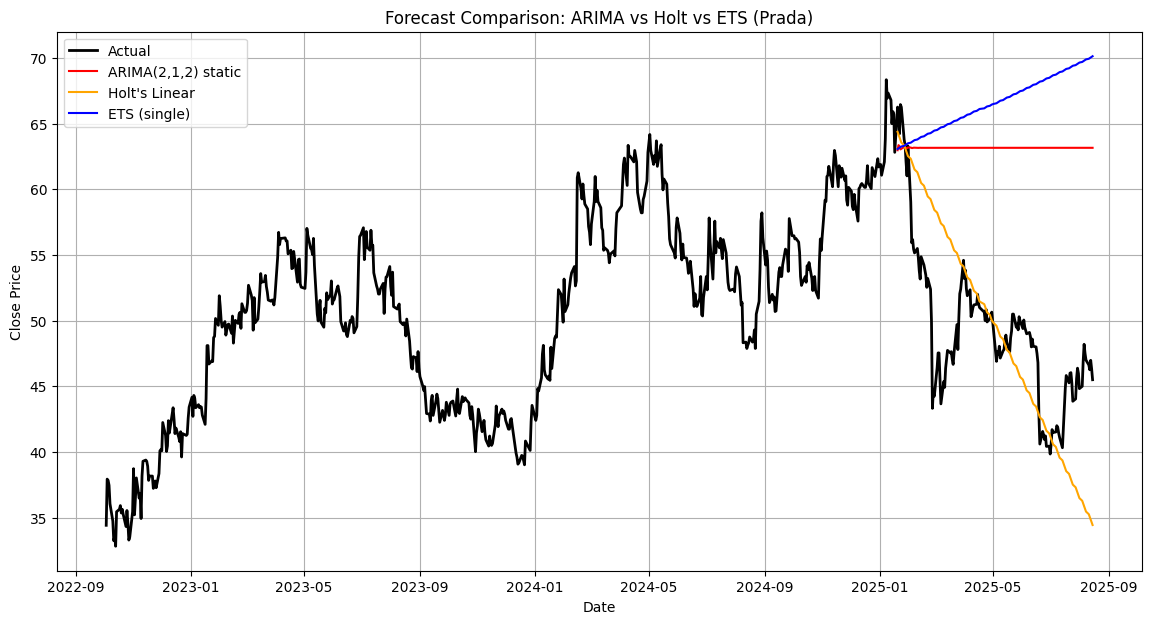

In [70]:
plt.figure(figsize=(14,7))
# Actual prices (using index as dates)
plt.plot(prada.index, prada['Close'], label='Actual', color='black', linewidth=2)
# ARIMA static
plt.plot(test_set.index, forecast_arima_static, label='ARIMA(2,1,2) static', color='red')
# Holt’s Linear
plt.plot(test_set.index, forecast_holt_best, label="Holt's Linear", color='orange')
# ETS single fit
plt.plot(test_set.index, forecast_ets, label='ETS (single)', color='blue')
plt.legend()
plt.title('Forecast Comparison: ARIMA vs Holt vs ETS (Prada)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

##Regime Switching

In [32]:
prada['log_return'] = np.log(prada['Close']) - np.log(prada['Close'].shift(1))
prada.dropna(inplace=True)
prada

,Date,Close,Volume,Ticker,log_return
1,2022-10-03,34.411480,370488.0,1913.HK,0.008208
2,2022-10-05,37.927639,941095.0,1913.HK,0.097290
3,2022-10-06,37.833874,306957.0,1913.HK,-0.002475
4,2022-10-07,37.458817,170652.0,1913.HK,-0.009963
5,2022-10-10,36.052353,411454.0,1913.HK,-0.038270
...,...,...,...,...,...
730,2025-09-22,46.619999,941766.0,1913.HK,-0.008118
731,2025-09-23,46.259998,1813594.0,1913.HK,-0.007752
732,2025-09-24,46.980000,2266940.0,1913.HK,0.015444
733,2025-09-25,46.320000,2847462.0,1913.HK,-0.014148


In [33]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
model_regime = MarkovRegression(prada['log_return'], k_regimes=3, trend='c', switching_variance=True)
result_regime = model_regime.fit(disp = False)
print(result_regime.summary())

                        Markov Switching Model Results                        
Dep. Variable:             log_return   No. Observations:                  734
Model:               MarkovRegression   Log Likelihood                1696.906
Date:                Thu, 09 Oct 2025   AIC                          -3369.812
Time:                        02:29:19   BIC                          -3314.630
Sample:                             0   HQIC                         -3348.528
                                - 734                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0081      0.002     -4.504      0.000      -0.012      -0.005
sigma2         0.0002   4.13e-05      4.360      0.0

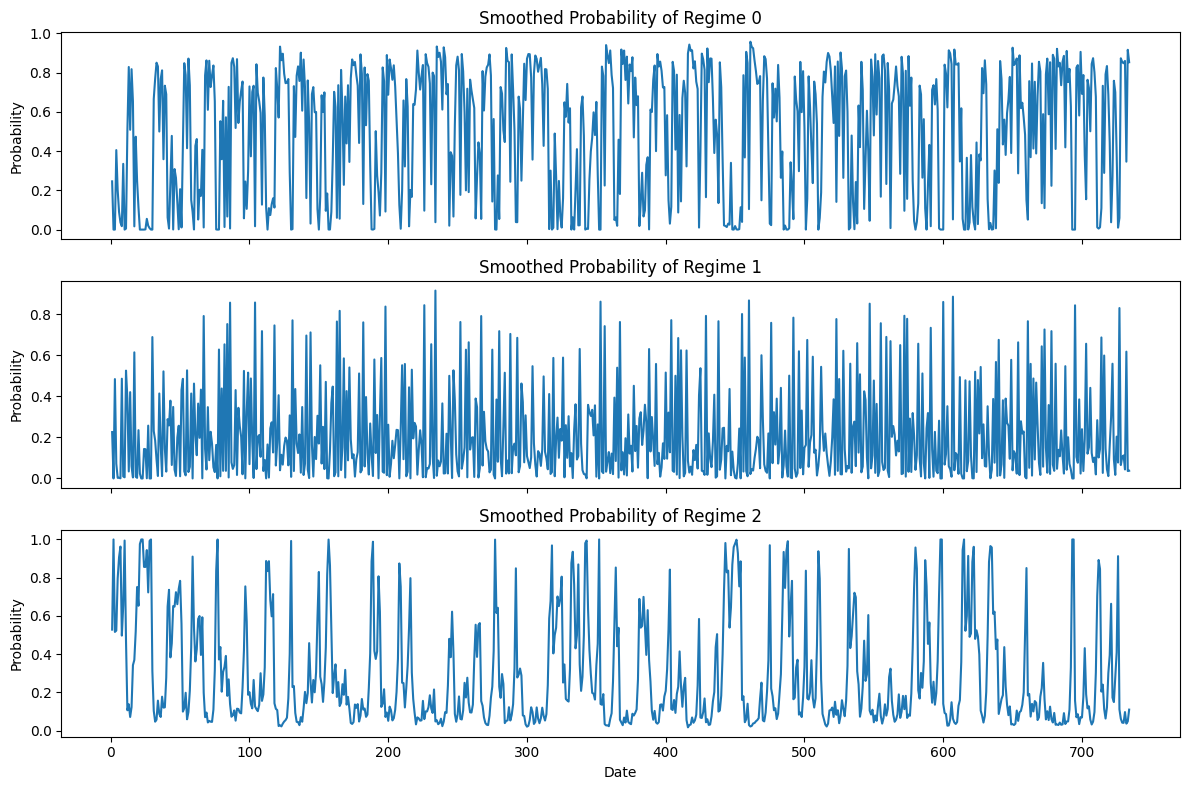

In [34]:
smoothed_probs = result_regime.smoothed_marginal_probabilities
smoothed_probs.index = prada.index
fig, axes = plt.subplots(3, figsize=(12, 8), sharex=True)
for i in range(3):
    axes[i].plot(smoothed_probs.index, smoothed_probs[i])
    axes[i].set_title(f"Smoothed Probability of Regime {i}")
    axes[i].set_ylabel('Probability')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [35]:
prada['regime'] = result_regime.smoothed_marginal_probabilities.idxmax(axis=1)
regime_stats = prada.groupby('regime')['log_return'].agg(['mean', 'std'])
print(regime_stats)

            mean       std
regime                    
0      -0.008708  0.011464
1       0.020297  0.010089
2       0.007502  0.041591


In [36]:
params = result_regime.params
k_regimes = 3
n_trans_params = (k_regimes - 1) * k_regimes
trans_params = params[-n_trans_params:]
transition_matrix = np.zeros((k_regimes, k_regimes))
index = 0
for i in range(k_regimes):
    if i < k_regimes - 1:
        logits = trans_params[index:index + k_regimes]
        index += k_regimes
        exp_logits = np.exp(logits)
        transition_matrix[i, :] = exp_logits / exp_logits.sum()
    else:
        transition_matrix[i, :] = 1.0 / k_regimes

In [41]:
import pandas as pd
prada['Date'] = pd.to_datetime(prada['Date'])
prada.set_index('Date', inplace=True)
def forecast_regime_probs(result_regime, transition_matrix, last_date, days=30, trading_days=True):
    current_probs = result_regime.smoothed_marginal_probabilities.iloc[-1].values
    future_probs = []
    for _ in range(days):
        next_probs = np.dot(current_probs, transition_matrix)
        future_probs.append(next_probs)
        current_probs = next_probs
    future_probs_df = pd.DataFrame(
        future_probs,
        columns=[f'Regime_{i}' for i in range(transition_matrix.shape[0])]
    )
    if trading_days:
        future_probs_df.index = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=days)
    else:
        future_probs_df.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days)

    return future_probs_df
last_date = pd.to_datetime(df.index[-1])
future_probs_df = forecast_regime_probs(result_regime, transition_matrix, last_date, days=30)
print(future_probs_df.head(10))

            Regime_0  Regime_1  Regime_2
2025-09-30  0.329995  0.336602  0.333404
2025-10-01  0.331994  0.334556  0.333450
2025-10-02  0.331986  0.334564  0.333450
2025-10-03  0.331986  0.334564  0.333450
2025-10-06  0.331986  0.334564  0.333450
2025-10-07  0.331986  0.334564  0.333450
2025-10-08  0.331986  0.334564  0.333450
2025-10-09  0.331986  0.334564  0.333450
2025-10-10  0.331986  0.334564  0.333450
2025-10-13  0.331986  0.334564  0.333450
